## Physics Informed Neural Networks (PINNs): Solving the Burgers Equation Step-by-Step Tutorial

- https://youtu.be/7Es1ZWiMq0Y?si=pI1EUZzfox3qsW-Y

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

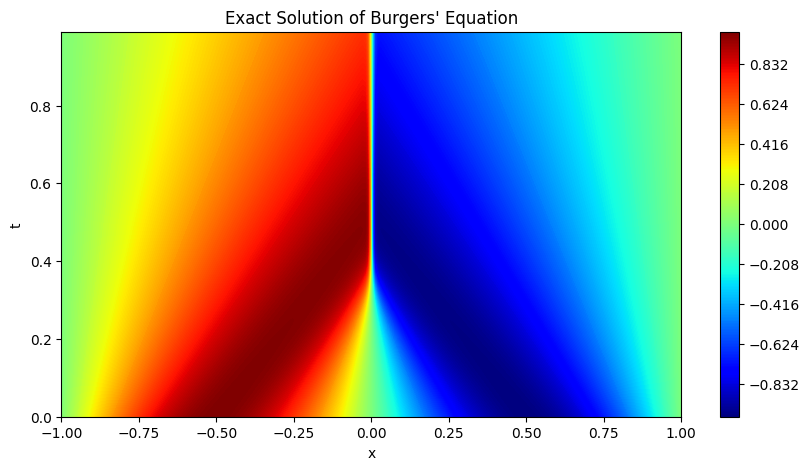

In [64]:
data = np.load("Burgers.npz")
x_ref, t_ref, exact = data["x"], data["t"], data["usol"].T
x_ref, t_ref = np.meshgrid(x_ref, t_ref)

plt.figure(figsize=(10, 5))
plt.contourf(x_ref, t_ref, exact, levels=250, cmap="jet")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("t")
plt.title("Exact Solution of Burgers' Equation")
plt.show()

In [65]:
x_values = torch.linspace(-1, 1, 25).view(-1, 1)
t_values = torch.linspace(0, 1, 25).view(-1, 1)
x_collection, t_collection = torch.meshgrid(x_values.squeeze(), t_values.squeeze(), indexing="xy")
x_collection = x_collection.reshape(-1, 1)
t_collection = t_collection.reshape(-1, 1)
print(x_collection.shape, t_collection.shape)

x_boundary_left = torch.full_like(t_values, -1.0)
x_boundary_right = torch.full_like(t_values, 1)
t_boundary_points = t_values

t_initial_condition = torch.zeros_like(x_values)
x_initial_condition = x_values

torch.Size([625, 1]) torch.Size([625, 1])


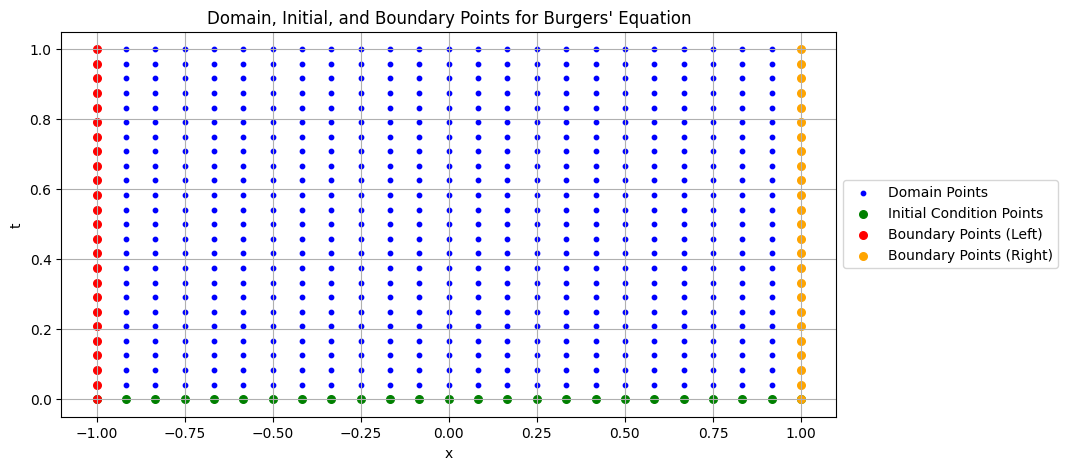

In [66]:
x_collection_np = x_collection.numpy()
t_collection_np = t_collection.numpy()

x_initial_condition_np = x_initial_condition.numpy()
t_initial_condition_np = t_initial_condition.numpy()

x_boundary_left_np = x_boundary_left.numpy()
x_boundary_right_np = x_boundary_right.numpy()
t_boundary_points_np = t_boundary_points.numpy()

plt.figure(figsize=(10, 5))
plt.scatter(x_collection_np, t_collection_np, label="Domain Points", marker="o", color="blue", s=10)
plt.scatter(x_initial_condition_np, t_initial_condition_np, label="Initial Condition Points", marker="o", color="green", s=30)
plt.scatter(x_boundary_left_np, t_boundary_points_np, label="Boundary Points (Left)", marker="o", color="red", s=30)
plt.scatter(x_boundary_right_np, t_boundary_points_np, label="Boundary Points (Right)", marker="o", color="orange", s=30)
plt.xlabel("x")
plt.ylabel("t")
plt.title("Domain, Initial, and Boundary Points for Burgers' Equation")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

In [67]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1),
        )
        
    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        return self.hidden(inputs)

In [72]:
def gradient(y, x):
    return torch.autograd.grad(y, x, 
                grad_outputs=torch.ones_like(y), create_graph=True, retain_graph=True)[0]

def pde_residual(x, t, model):
    x.requires_grad = True
    t.requires_grad = True
    u = model(x, t)
    u_x = gradient(u, x)
    u_t = gradient(u, t)
    u_xx = gradient(u_x, x)
    return u_t + u * u_x - (0.01/np.pi) * u_xx

def initial_condition(x):
    return -torch.sin(np.pi * x)

def boundary_condition_left(t):
    return torch.zeros_like(t)

def boundary_condition_right(t):
    return torch.zeros_like(t)

In [74]:
x = torch.linspace(-1, 1, 200).view(-1, 1)
t = torch.linspace(0, 1, 100).view(-1, 1)
x_train, t_train = torch.meshgrid(x.squeeze(), t.squeeze(), indexing="xy")
x_train = x_train.reshape(-1, 1)
t_train = t_train.reshape(-1, 1)

# x_test = torch.linspace(-1, 1, 100).view(-1, 1)
# t_test = torch.linspace(0, 1, 100).view(-1, 1)
# x_test, t_test = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing="xy")
# x_test = x_test.reshape(-1, 1)
# t_test = t_test.reshape(-1, 1)

model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 1000
for epoch in range(1, n_epochs + 1):
    model.train()
    
    t_init = torch.zeros_like(x)
    u_pred_ic = model(x, t_init)           # u(x, 0) for initial condition
    loss_ic = torch.mean(torch.square(u_pred_ic - initial_condition(x)))  # Initial condition loss
    
    x_left = torch.full_like(t, -1)
    u_pred_left = model(x_left, t)   # u(-1, t) for left boundary condition
    loss_bc_left = torch.mean(torch.square(u_pred_left - boundary_condition_left(t)))

    x_right = torch.full_like(t, 1)
    u_pred_right = model(x_right, t)   # u(1, t) for right boundary condition
    loss_bc_right = torch.mean(torch.square(u_pred_right - boundary_condition_right(t)))  # Boundary condition loss
    
    residual = pde_residual(x_train, t_train, model) # PDE residual
    loss_pde = torch.mean(torch.square(residual))
    
    # model.eval()
    # with torch.no_grad():
    #     u_pred_test = model(x_test, t_test)
    #     loss_test = torch.mean(u_pred_test, )
    
    loss = loss_ic + loss_bc_left + loss_bc_right + loss_pde
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch[{epoch}/{n_epochs}] Loss: {loss.item():.2e}")
    

Epoch[100/1000] Loss: 3.55e-01
Epoch[200/1000] Loss: 1.55e-01
Epoch[300/1000] Loss: 1.45e-01
Epoch[400/1000] Loss: 1.31e-01
Epoch[500/1000] Loss: 1.22e-01
Epoch[600/1000] Loss: 1.15e-01
Epoch[700/1000] Loss: 1.08e-01
Epoch[800/1000] Loss: 1.04e-01
Epoch[900/1000] Loss: 1.02e-01
Epoch[1000/1000] Loss: 9.96e-02


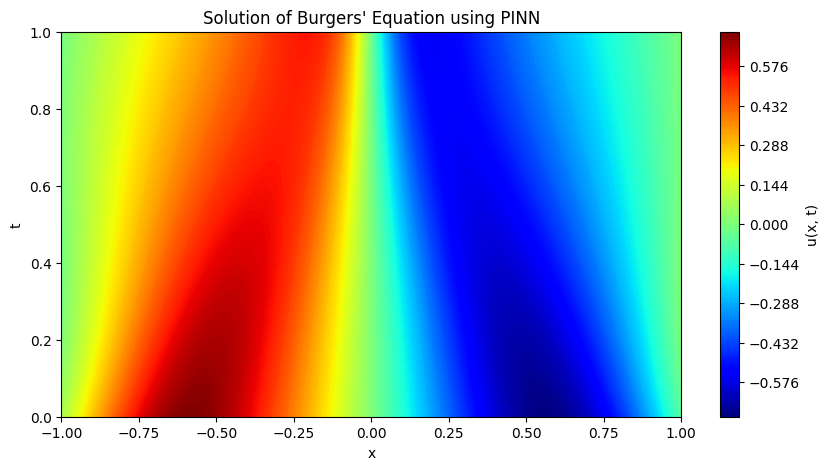

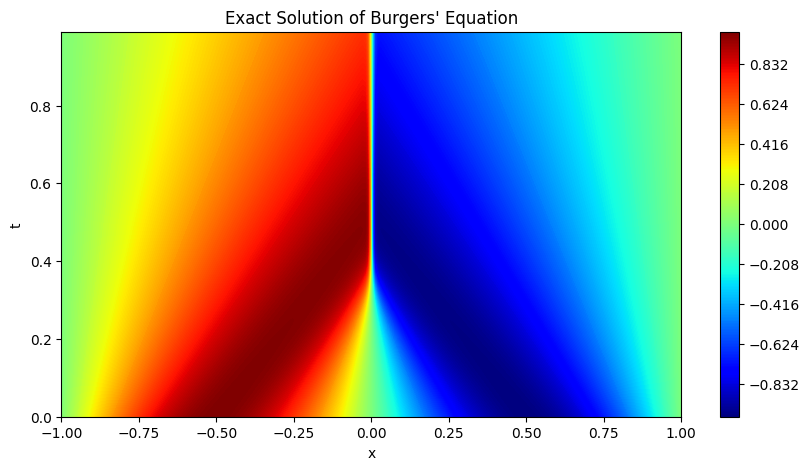

In [75]:
x_test = torch.linspace(-1, 1, 100).view(-1, 1)
t_test = torch.linspace(0, 1, 100).view(-1, 1)
x_test, t_test = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing="xy")
x_test = x_test.reshape(-1, 1)
t_test = t_test.reshape(-1, 1)

model.eval()
with torch.no_grad():
    u_pred = model(x_test, t_test).numpy()

x_test = x_test.numpy().reshape(100, 100)
t_test = t_test.numpy().reshape(100, 100)
u_pred = u_pred.reshape(100, 100)

fig = plt.figure(figsize=(10, 5))
plt.contourf(x_test, t_test, u_pred, levels=250, cmap="jet")
plt.colorbar(label="u(x, t)")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Solution of Burgers' Equation using PINN")
plt.show()

plt.figure(figsize=(10, 5))
plt.contourf(x_ref, t_ref, exact, levels=250, cmap="jet")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("t")
plt.title("Exact Solution of Burgers' Equation")
plt.show()

In [ ]:
time_slices = [0.25, 0.50, 0.75]
num_plots = len(time_slices)
cols = 2
rows = (num_plots // cols) + (num_plots % cols)  # Calculate the number of rows needed for subplots

fig, axes = plt.subplots(rows, cols, figsize=(12, 5 * rows))  # Create a figure with subplots
axes = axes.flatten()  # Flatten the axes array for easier indexing
for i, t_val in enumerate(time_slices):
    idx_ref = np.argmin(np.abs(t_ref[:, 0] - t_val))
    u_ref_slice = exact[idx_ref, :]  # Extract the solution at the given time slice from the reference solution
    